### This notebook examines differences in SST contrast output from as few different GLM variations

In [1]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

from Neuro_Plotting.Ref import SurfRef
from Neuro_Plotting.Plot import Plot_Surf_Collage
import matplotlib.pyplot as plt

In [2]:
def load_subj_data(dr, subj):
    
    rel_files = sorted([os.path.join(dr, f) for f in os.listdir(dr) if subj in f])
    
    if len(rel_files) != 2:
        return None
    
    lh = nib.load(rel_files[0]).get_fdata().squeeze()
    rh = nib.load(rel_files[1]).get_fdata().squeeze()
    
    concat = np.concatenate([lh, rh])
    return concat

def get_resid(to_resid, data):
    
    to_resid = np.array(to_resid)
    data = np.array(data)
    
    model = LinearRegression().fit(to_resid, data)
    dif = data - model.predict(to_resid)
    resid_data = model.intercept_ + dif
    
    return resid_data

def get_cohens(data):

    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    cohen = mean / std
    
    return cohen

def get_no_mwall_corr(d1, d2):
    
    lh_medial = np.load('img_data/lh_medial_wall.npy').squeeze()
    rh_medial = np.load('img_data/rh_medial_wall.npy').squeeze()
    medial = np.concatenate([lh_medial, rh_medial+(len(d1)//2)])
    not_medial = [i for i in np.arange(len(d1)) if i not in medial]
    print(len(not_medial), d1[not_medial].shape)
    
    return np.corrcoef(d1[not_medial], d2[not_medial])[0][1]

def plot(d, title, vmin=None, vmax=None, threshold=.1):
    
    def split(d):
        
        lh = d[:len(d)//2]
        rh = d[len(d)//2:]
        
        lh_medial = np.load('img_data/lh_medial_wall.npy').squeeze()
        rh_medial = np.load('img_data/rh_medial_wall.npy').squeeze()
        
        lh[lh_medial] = 0
        rh[rh_medial] = 0
        
        return [lh, rh]

    data_dr = '/home/sage/Neuro_Plotting/data/'
    surf_ref = SurfRef(data_dr, space='fsaverage5', parc='desikan')
    
    figure, axes, smf = Plot_Surf_Collage(data = split(d),
                                          ref = surf_ref,
                                          surf_mesh = 'inflated',
                                          bg_map = 'sulc',
                                          view = 'standard',
                                          cmap = 'cold_hot',
                                          title = title,
                                          vmin=vmin,
                                          vmax=vmax,
                                          title_sz = 22,
                                          threshold = threshold,
                                          wspace = 0,
                                          hspace = 0,
                                          figsize = (15, 10),
                                          midpoint = None,
                                          avg_method = 'mean',
                                          bg_on_data = True,
                                          alpha = 1,
                                          colorbar = True)

In [3]:
def load_data(dr, overlap_drs=None, overlap_subjs=None):
    
    subjs = set([f.split('_')[0] for f in os.listdir(dr)])
    print('original len', len(subjs))
    
    if overlap_subjs is not None:
        for to_overlap in overlap_subjs:
            to_overlap = set(to_overlap)
            
            print('overlap with', len(to_overlap))
            subjs = subjs.intersection(to_overlap)
            print('new len', len(subjs))
            
    if overlap_drs is not None:
        for overlap_dr in overlap_drs:
            to_overlap = set([f.split('_')[0] for f in os.listdir(overlap_dr)])

            print('overlap with', len(to_overlap))
            subjs = subjs.intersection(to_overlap)
            print('new len', len(subjs))
            
    data, loaded_subjects = [], []
    for subj in subjs:
        subj_data = load_subj_data(dr, subj)
        
        if subj_data is not None:
            data.append(subj_data)
            loaded_subjects.append(subj)
            
    data = np.array(data)
    print('loaded data shape', data.shape)
    
    return data, loaded_subjects

def load_corresponding_data(dr, subjs):
    
    data = []
    for subj in subjs:
        subj_data = load_subj_data(dr, subj)
        
        if subj_data is not None:
            data.append(subj_data)
        else:
            print('Warning, missing 1 lh or rh')
            
    data = np.array(data)
    print(data.shape)
    
    return data

In [4]:
with open('clean_subj_subset.txt', 'r') as f:
    lines = f.readlines()
    clean_subjs = [l.strip().replace('NDAR_', '') for l in lines]

print(len(clean_subjs))

7115


In [5]:
## Load the covars
covars = pd.read_csv('alt_img_data/covars_SST.csv', index_col='src_subject_id')
covars = covars.drop('tfmri_sst_all_beh_total_meanrt', axis=1)
covars.index = [i.replace('NDAR_', '') for i in covars.index]
len(covars)

6206

### 1. Look at comparison between GLM run with 0 ssd trials removed and the baseline GLM w/ 0 ssd trials not excluded

In [6]:
zero_ssd_dr = 'img_data/SST_0SSD/'
base_ssd_dr = 'img_data/SST_base/'

print('zero ssd')
z_data, z_subjs = load_data(zero_ssd_dr, overlap_subjs=[clean_subjs, covars.index],
                            overlap_drs=[base_ssd_dr])

print()
b_data = load_corresponding_data(base_ssd_dr, z_subjs)

print()
z_covars = covars.loc[z_subjs]
z_covars.shape

zero ssd
original len 5934
overlap with 7115
new len 5064
overlap with 6206
new len 5064
overlap with 5939
new len 5064
loaded data shape (5064, 20484)

(5064, 20484)



(5064, 35)

/home/sage/anaconda3/envs/home/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/sage/anaconda3/envs/home/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


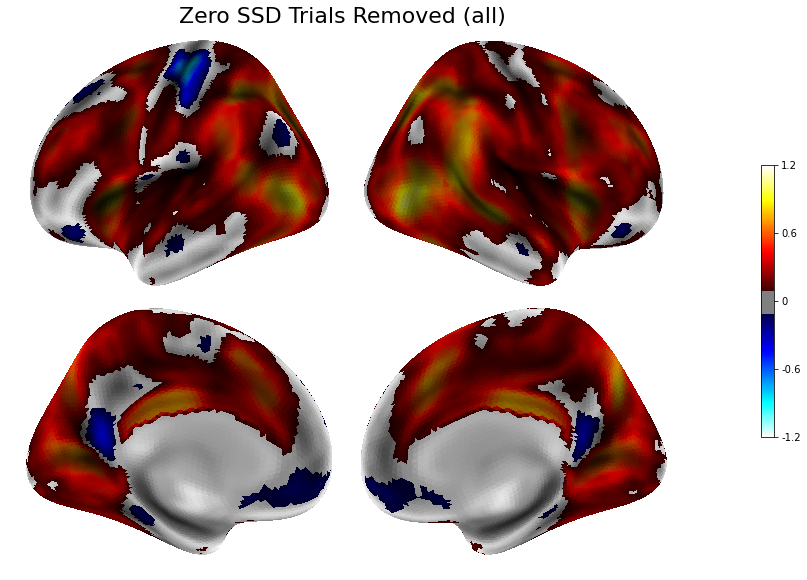

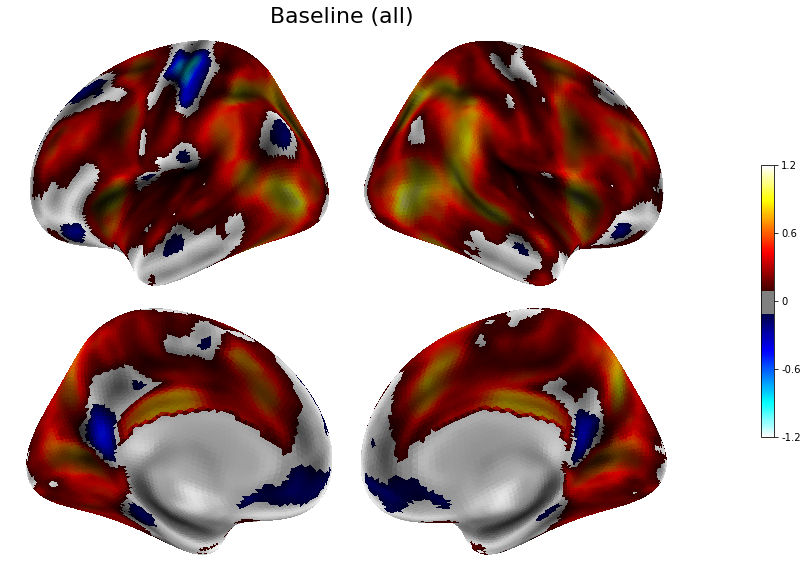

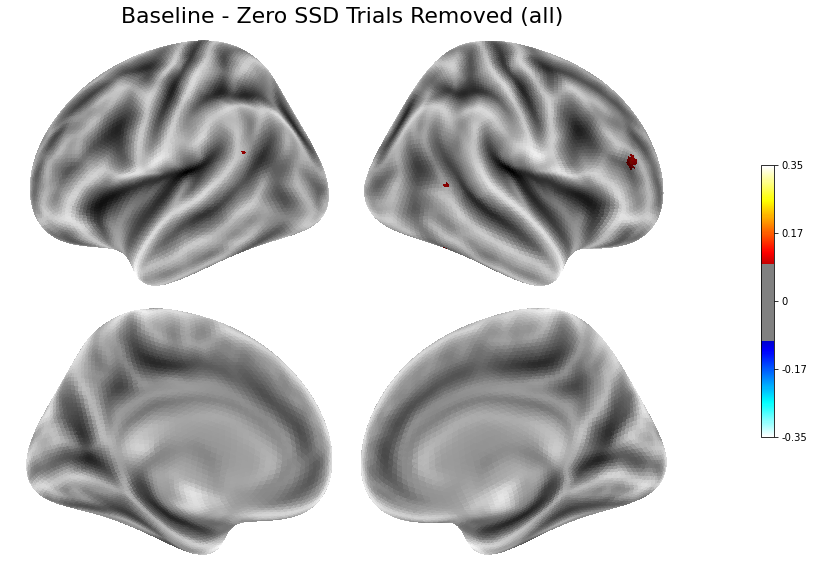

18715 (18715,)
0.9983210640265705


In [7]:
z_cohens = get_cohens(get_resid(z_covars, z_data))
b_cohens = get_cohens(get_resid(z_covars, b_data))

plot(z_cohens, 'Zero SSD Trials Removed (all)', vmin=-1.2, vmax=1.2)
plt.savefig('brain_figures/zero_ssd_all.png', dpi=400)
plt.show()

plot(b_cohens, 'Baseline (all)', vmin=-1.2, vmax=1.2)
plt.savefig('brain_figures/baseline_all.png', dpi=400)
plt.show()

plot(b_cohens - z_cohens, 'Baseline - Zero SSD Trials Removed (all)', 
     threshold=.1, vmin=-.35, vmax=.35)
plt.savefig('brain_figures/baseline_minus_zero_ssd_all.png', dpi=400)
plt.show()

print(get_no_mwall_corr(z_cohens, b_cohens))

### 2. Same comparison but on just the subset of subjects with > 1 zero ssd trial

In [8]:
with open('clean_over1_zeroSSD.txt', 'r') as f:
    lines = f.readlines()
    clean_over1_zero_subjs = [l.strip().replace('NDAR_', '') for l in lines]

print(len(clean_over1_zero_subjs))

3509


In [9]:
print('zero ssd')
z_data, z_subjs = load_data(zero_ssd_dr, overlap_subjs=[clean_over1_zero_subjs, covars.index],
                            overlap_drs=[base_ssd_dr])

print()
b_data = load_corresponding_data(base_ssd_dr, z_subjs)

print()
z_covars = covars.loc[z_subjs]
z_covars.shape

zero ssd
original len 5934
overlap with 3509
new len 2416
overlap with 6206
new len 2416
overlap with 5939
new len 2416
loaded data shape (2416, 20484)

(2416, 20484)



(2416, 35)

/home/sage/anaconda3/envs/home/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/sage/anaconda3/envs/home/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


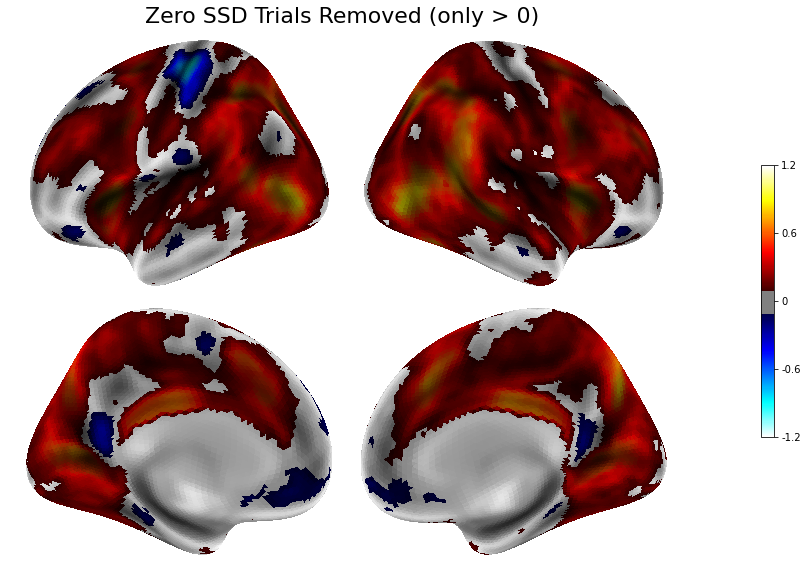

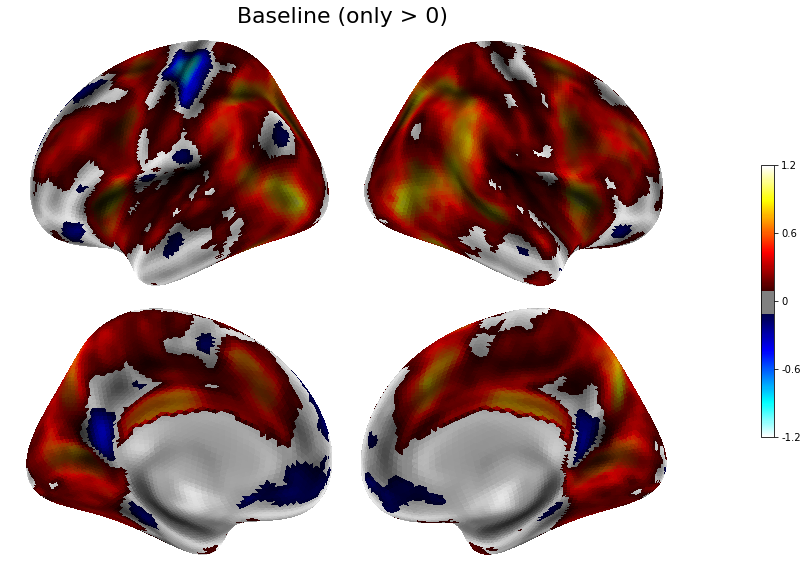

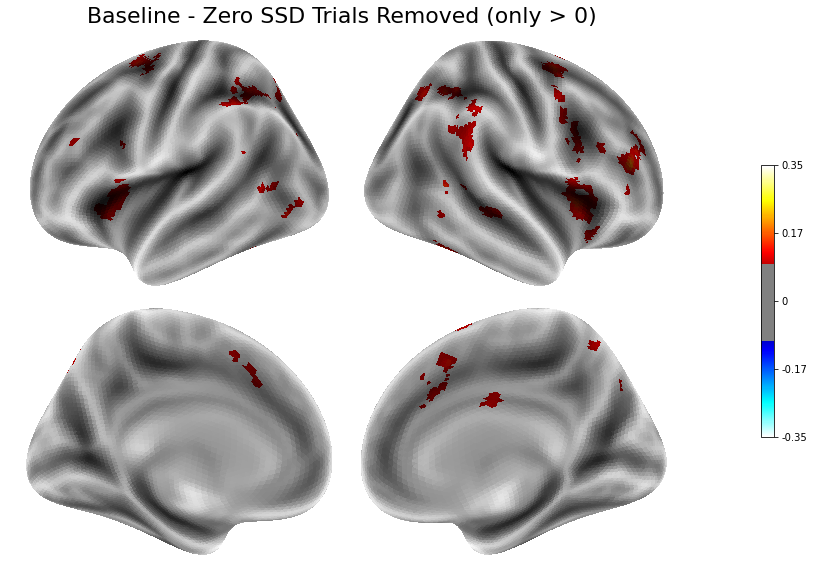

18715 (18715,)
0.993560653691297


In [10]:
z_cohens = get_cohens(get_resid(z_covars, z_data))
b_cohens = get_cohens(get_resid(z_covars, b_data))

plot(z_cohens, 'Zero SSD Trials Removed (only > 0)', vmin=-1.2, vmax=1.2)
plt.savefig('brain_figures/zero_ssd_subset.png', dpi=400)
plt.show()

plot(b_cohens, 'Baseline (only > 0)', vmin=-1.2, vmax=1.2)
plt.savefig('brain_figures/baseline_subset.png', dpi=400)
plt.show()

plot(b_cohens - z_cohens, 'Baseline - Zero SSD Trials Removed (only > 0)',
     threshold=.1, vmin=-.35, vmax=.35)
plt.savefig('brain_figures/baseline_minus_zero_ssd_subset.png', dpi=400)
plt.show()

print(get_no_mwall_corr(z_cohens, b_cohens))

### 3. Look at comparison between GLM run with < 150 ssd trials removed and the baseline GLM

In [11]:
split_ssd_dr = 'img_data/SST_split_SSD/'

print('split ssd')
s_data, s_subjs = load_data(split_ssd_dr, overlap_subjs=[clean_subjs, covars.index],
                            overlap_drs=[base_ssd_dr])

print()
b_data = load_corresponding_data(base_ssd_dr, s_subjs)

print()
s_covars = covars.loc[s_subjs]
s_covars.shape

split ssd
original len 5928
overlap with 7115
new len 5058
overlap with 6206
new len 5058
overlap with 5939
new len 5058
loaded data shape (5058, 20484)

(5058, 20484)



(5058, 35)

/home/sage/anaconda3/envs/home/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/sage/anaconda3/envs/home/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


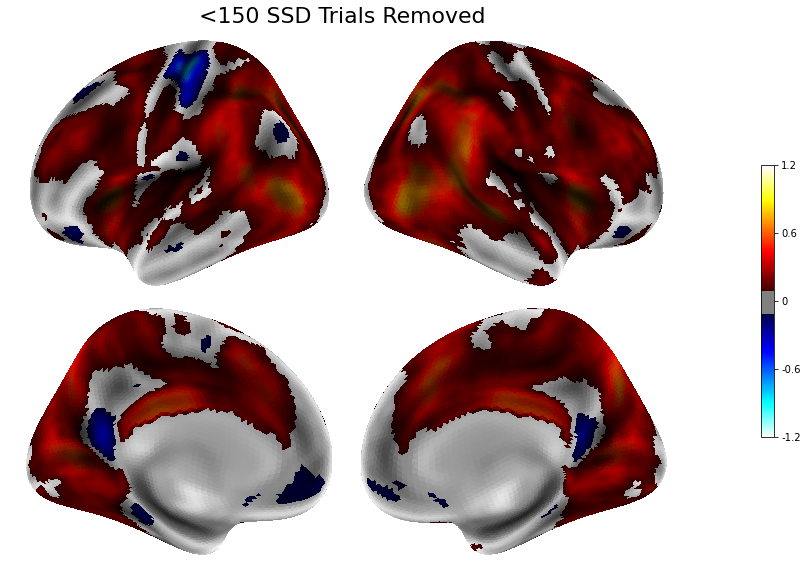

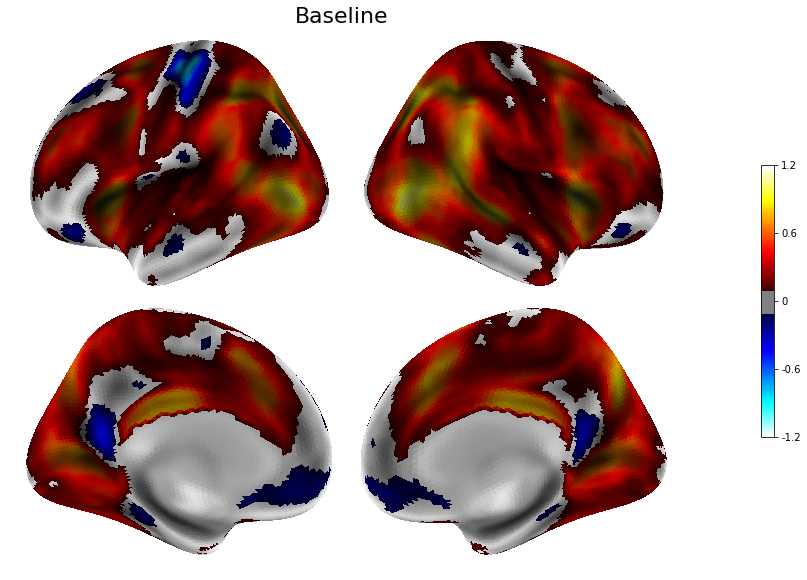

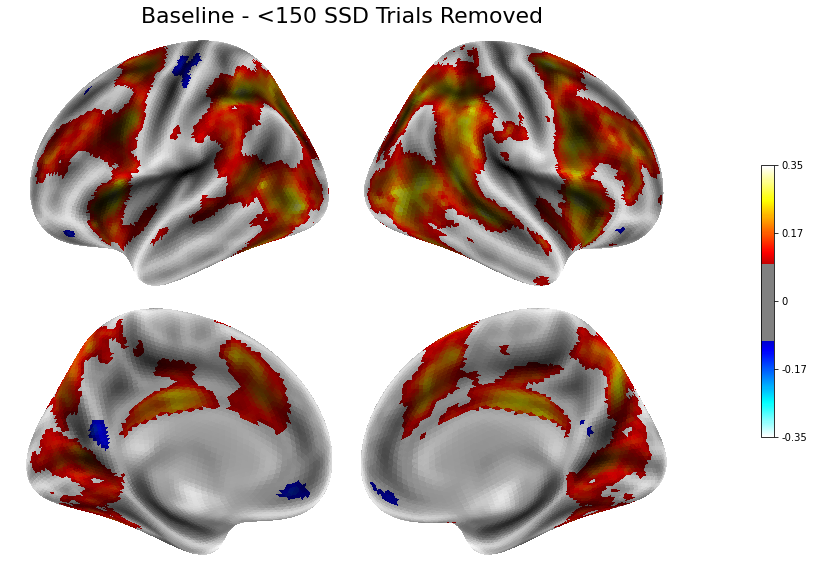

18715 (18715,)
0.990557888031586


In [12]:
s_cohens = get_cohens(get_resid(s_covars, s_data))
b_cohens = get_cohens(get_resid(s_covars, b_data))

plot(s_cohens, '<150 SSD Trials Removed', vmin=-1.2, vmax=1.2)
plt.savefig('brain_figures/split_ssd.png', dpi=400)
plt.show()

plot(b_cohens, 'Baseline', vmin=-1.2, vmax=1.2)
plt.savefig('brain_figures/baseline_split_overlap.png', dpi=400)
plt.show()

plot(b_cohens - s_cohens, 'Baseline - <150 SSD Trials Removed',
     threshold=.1, vmin=-.35, vmax=.35)
plt.savefig('brain_figures/baseline_minus_split_ssd.png', dpi=400)
plt.show()

print(get_no_mwall_corr(s_cohens, b_cohens))

### 4. Look at comparison between GLM run with first 10 trials removed and the baseline GLM

In [13]:
f_dr = 'img_data/SST_1st_10stop'

print('first 10 stops removed')
f_data, f_subjs = load_data(f_dr, overlap_subjs=[clean_subjs, covars.index],
                            overlap_drs=[base_ssd_dr])

print()
b_data = load_corresponding_data(base_ssd_dr, f_subjs)

print()
f_covars = covars.loc[f_subjs]
f_covars.shape

first 10 stops removed
original len 5936
overlap with 7115
new len 5067
overlap with 6206
new len 5067
overlap with 5939
new len 5067
loaded data shape (5067, 20484)

(5067, 20484)



(5067, 35)

/home/sage/anaconda3/envs/home/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/sage/anaconda3/envs/home/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


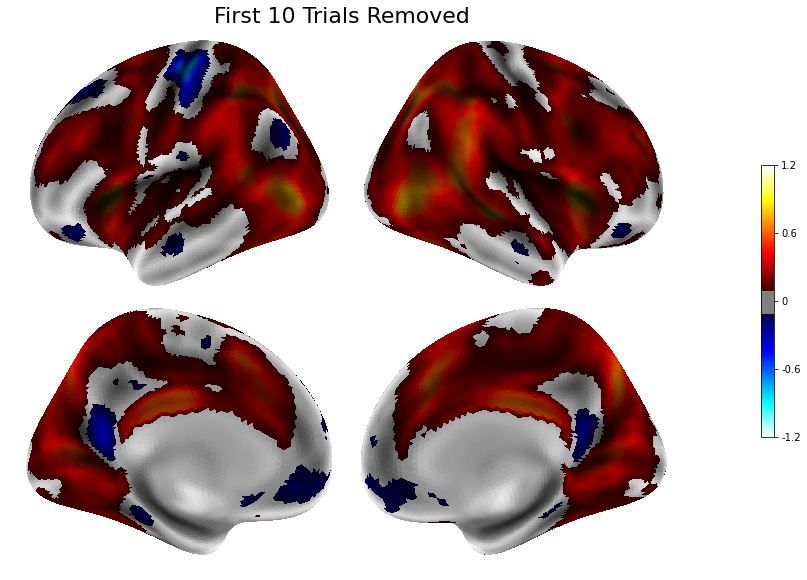

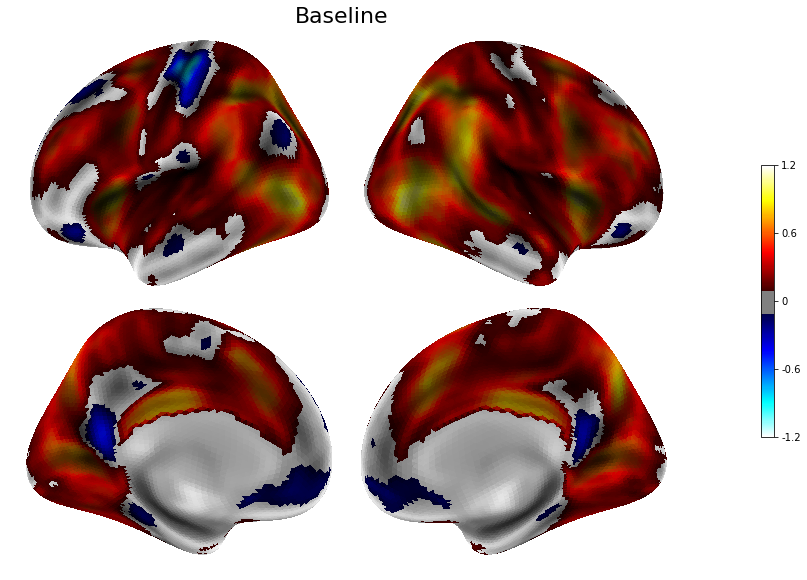

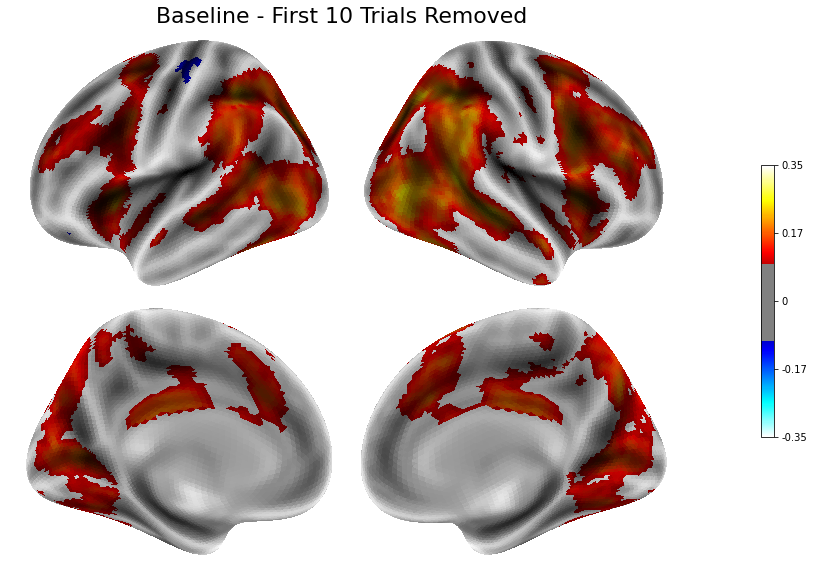

18715 (18715,)
0.9937137939098696


In [14]:
f_cohens = get_cohens(get_resid(f_covars, f_data))
b_cohens = get_cohens(get_resid(f_covars, b_data))

plot(f_cohens, 'First 10 Trials Removed', vmin=-1.2, vmax=1.2)
plt.savefig('brain_figures/ten_stops_removed.png', dpi=400)
plt.show()

plot(b_cohens, 'Baseline', vmin=-1.2, vmax=1.2)
plt.savefig('brain_figures/baseline_ten_stops_removed_overlap.png', dpi=400)
plt.show()

plot(b_cohens - f_cohens, 'Baseline - First 10 Trials Removed',
     threshold=.1, vmin=-.35, vmax=.35)
plt.savefig('brain_figures/baseline_minus_ten_stops_removed.png', dpi=400)
plt.show()

print(get_no_mwall_corr(f_cohens, b_cohens))

### 5. Compare baseline 3.0 to baseline 2.1

In [15]:
base2_dr = 'img_data/SST_2_base'

print('baseline2.1')
b2_data, b2_subjs = load_data(base2_dr, overlap_subjs=[clean_subjs, covars.index],
                              overlap_drs=[base_ssd_dr])

print()
b3_data = load_corresponding_data(base_ssd_dr, b2_subjs)

print()
b_covars = covars.loc[b2_subjs]
b_covars.shape

baseline2.1
original len 8724
overlap with 7115
new len 6652
overlap with 6206
new len 5256
overlap with 5939
new len 5065
loaded data shape (5065, 20484)

(5065, 20484)



(5065, 35)

/home/sage/anaconda3/envs/home/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


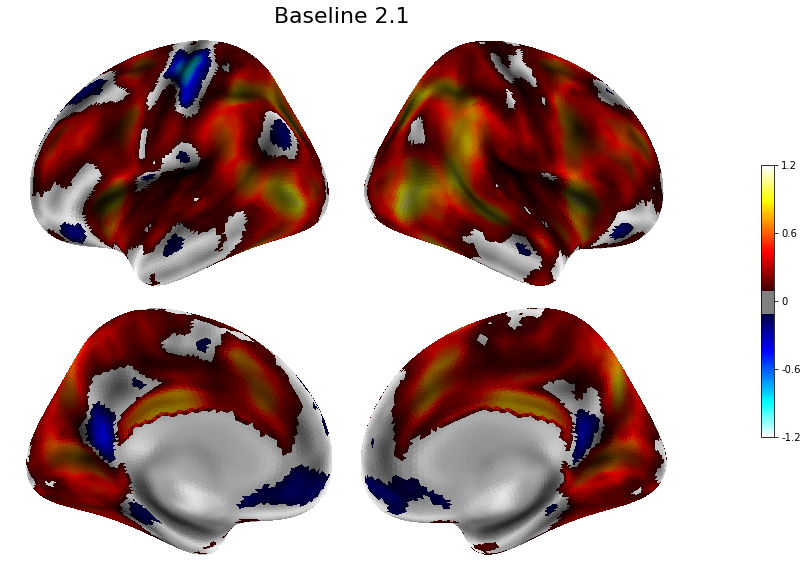

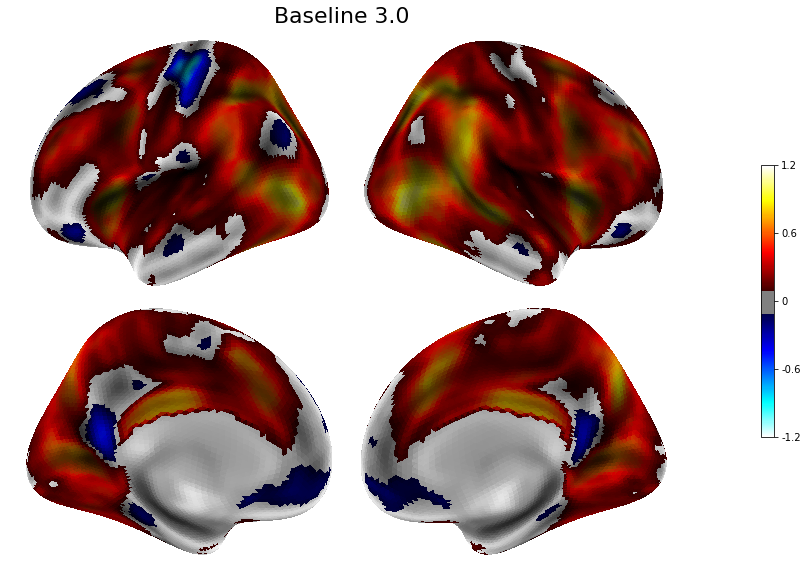

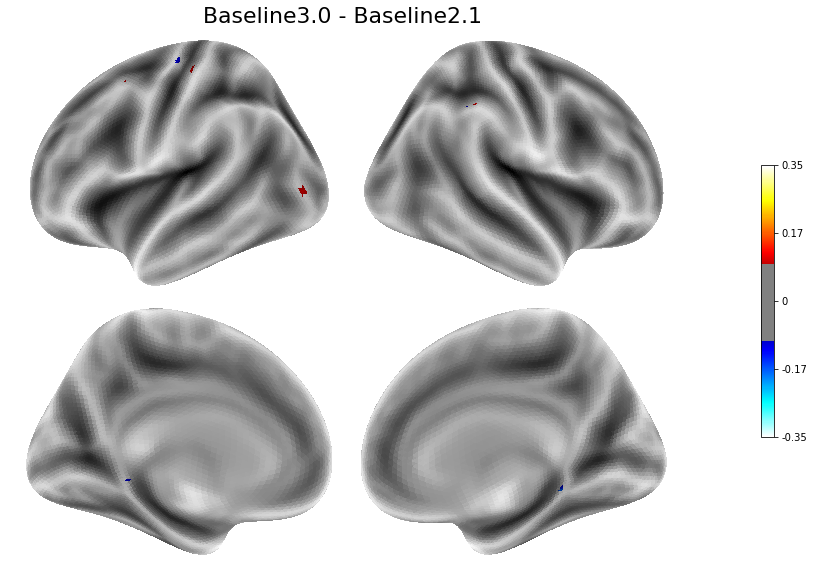

18715 (18715,)
0.9954844470889856


In [16]:
b2_cohens = get_cohens(get_resid(b_covars, b2_data))
b3_cohens = get_cohens(get_resid(b_covars, b3_data))

plot(b2_cohens, 'Baseline 2.1', vmin=-1.2, vmax=1.2)
plt.savefig('brain_figures/baseline2.png', dpi=400)
plt.show()

plot(b3_cohens, 'Baseline 3.0', vmin=-1.2, vmax=1.2)
plt.savefig('brain_figures/baseline3.png', dpi=400)
plt.show()

plot(b3_cohens - b2_cohens, 'Baseline3.0 - Baseline2.1',
     threshold=.1, vmin=-.35, vmax=.35)
plt.savefig('brain_figures/baseline3_minus_baseline2.png', dpi=400)
plt.show()

print(get_no_mwall_corr(b2_cohens, b3_cohens))